## 🎥🍿🍬 Movie Recommender System 🍬🍿🎥

#### Group 2: Anish Adimulam, Saad Ahmad, Sydney Johnson, Yvette Soto, Trinity Thao, Saye Xavier

In this final project, we create a recommender system that showcases movies to viewers based on their rating history. The movies shown will be based on the type of rating(s) the user has given per genre of movie they watched. The goal of this final project is to showcase the skills we have learned throughout the semester to create a usable product with our dataset.

Our dataset is the __Movielens Latest Small__ dataset. The dataset can be found at: https://grouplens.org/datasets/movielens/latest/

This dataset consists of four _csv_ files:
- movies.csv
- ratings.csv
- tags.csv
- links.csv

_In our project, we will only use the __movies.csv__ and __ratings.csv__ files to build our system._

The __movies.csv__ consists of the following:
- `movieID`
- `title`
- `genres`

The __ratings.csv__ consists of the following:
- `userID`
- `movieID`
- `rating`
- `timestamp`


Our methodology for this project is as follows:
- Perform __Pre-processing__
<br>
    - Check for missing values
    - Make sure IDs match between the movies.csv file and the ratings.csv file
<br>
- Conduct __Preference Analysis__
<br>
    - Identify movies with 4 stars or higher from the dataset and extract their genres
    - Count amount of times each genre shows up in a user's list
    - Create a preference vector based on their rating counts
<br>
- Finalize with __Cosine Similarity__
<br>
    - Normalize preference vector
    - Create a genre vector representing unwatched movies' genres (one-hot encoding will be used to represent genres)
    - Calculate cosine similarity between user's preference vector and each unwatched movie's genre vector
    - Store similarity scores for each unwatched movie and sort the movies in descending order based on score
    - Select the top K highest-ranked movies as the user's personalized recommendations

In [1]:
#Imports
import pandas as pd

In [2]:
#Load the data files
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

### Pre-Processing

In [3]:
#Check if any data is missing
movies_missing = movies.isnull().sum()
ratings_missing = ratings.isnull().sum()
print("Checking for missing data:")
print("Movies missing data:", movies_missing)
print("Ratings missing data:", ratings_missing)

Checking for missing data:
Movies missing data: movieId    0
title      0
genres     0
dtype: int64
Ratings missing data: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [4]:
#Checking if movies in ratings exist in movies file
rating_movie_ids = set(ratings['movieId'])
movie_ids = set(movies['movieId'])
movies_only_in_ratings = rating_movie_ids - movie_ids
if len(movies_only_in_ratings) == 0:
    print("All movie IDs match!")
else:
    print("Found", len(movies_only_in_ratings), "movies in ratings that don't exist in movies.csv")

All movie IDs match!


In [5]:
#Convert timestamp to date
from datetime import datetime
ratings['date'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

### Preference Analysis

In [6]:
# Split ratings into train and test
from sklearn.model_selection import train_test_split

# Initialize empty lists to collect the dataframes
train_dfs = []
test_dfs = []

# For each user, split their ratings into train (80%) and test (20%)
for user in ratings['userId'].unique():
    user_ratings = ratings[ratings['userId'] == user]
    user_train, user_test = train_test_split(user_ratings, test_size=0.2, random_state=42)
    train_dfs.append(user_train)
    test_dfs.append(user_test)

# Concatenate all the dataframes at once
train_ratings = pd.concat(train_dfs, ignore_index=True)
test_ratings = pd.concat(test_dfs, ignore_index=True)

In [7]:
#Find movies rated 4 stars or higher
good_ratings = train_ratings[train_ratings['rating'] >= 4.0]
print("Number of 4+ star ratings:", len(good_ratings))

Number of 4+ star ratings: 38742


In [8]:
#Split genres into lists
movies['genre_list'] = movies['genres'].str.split('|')

In [9]:
#Get all unique genres
all_genres = []
for index, row in movies.iterrows():
    genres = row['genre_list']
    for genre in genres:
        if genre not in all_genres:
            all_genres.append(genre)
all_genres.sort()
print("Found", len(all_genres), "unique genres")

Found 20 unique genres


In [10]:
# Create preference vectors for each user
user_preferences = {}
unique_users = ratings['userId'].unique()

for user in unique_users:
    # Get their highly rated movies
    user_good_ratings = good_ratings[good_ratings['userId'] == user]
    
    # Count each genre
    genre_counts = {}
    for genre in all_genres:
        genre_counts[genre] = 0
    
    # For each highly rated movie, add to genre counts
    for index, rating_row in user_good_ratings.iterrows():
        movie_id = rating_row['movieId']
        movie_row = movies[movies['movieId'] == movie_id]
        
        if len(movie_row) > 0:
            # Instead of .iloc[0], we'll convert to a list and take the first item
            movie_genres = list(movie_row['genre_list'])[0]
            for genre in movie_genres:
                genre_counts[genre] = genre_counts[genre] + 1

    # Creating the vector
    vector = []
    for genre in all_genres:
        vector.append(genre_counts[genre])
    
    user_preferences[user] = vector

### User 1 example (can remove) just put this here to make sure it worked.

In [11]:
# Show user preferences
print("\nExample - User 1 preferences:")
print("-" * 40)
for i, genre in enumerate(all_genres):
    count = user_preferences[1][i]
    if count > 0:  
        print(f"{genre}: {count}")

# Show top 5 preferred genres
print("\nUser 1's top preferred genres:")
user1_vector = user_preferences[1]
genre_counts = list(zip(all_genres, user1_vector))
sorted_genres = sorted(genre_counts, key=lambda x: x[1], reverse=True)

for genre, count in sorted_genres[:5]:
    if count > 0:
        print(f"{genre}: {count} movies")


Example - User 1 preferences:
----------------------------------------
Action: 62
Adventure: 57
Animation: 22
Children: 29
Comedy: 53
Crime: 28
Drama: 49
Fantasy: 31
Film-Noir: 1
Horror: 7
Musical: 16
Mystery: 9
Romance: 19
Sci-Fi: 25
Thriller: 34
War: 16
Western: 5

User 1's top preferred genres:
Action: 62 movies
Adventure: 57 movies
Comedy: 53 movies
Drama: 49 movies
Thriller: 34 movies


## Cosine Similarity

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
import numpy as np

# 1. One‑hot encode all movies by genre
mlb = MultiLabelBinarizer(classes=all_genres)
genre_matrix = pd.DataFrame(
    mlb.fit_transform(movies['genre_list']),
    index=movies['movieId'],
    columns=all_genres
)

# 2. Normalize each user’s preference vector
user_profiles_norm = {}
for uid, vec in user_preferences.items():
    v = np.array(vec, dtype=float)
    n = norm(v)
    user_profiles_norm[uid] = (v / n) if n > 0 else v

# 3. For each user, score all unseen movies and pick Top‑K
K = 10
recommendations = {}

for uid, uvec in user_profiles_norm.items():
    # movies user has already rated (train)
    seen = set(train_ratings[train_ratings['userId'] == uid]['movieId'])
    
    # candidate pool = all movies minus seen
    candidates = genre_matrix.drop(index=seen, errors='ignore')
    
    # compute cosine similarity
    sims = cosine_similarity(uvec.reshape(1, -1), candidates.values)[0]
    
    # grab the Top‑K movieIds
    top_k_ids = candidates.index[np.argsort(sims)[-K:][::-1]]
    recommendations[uid] = list(top_k_ids)

# 4. Peeking at a user's top 10 films, the first being the highest, as a test.
print("User 1 recommendations:", recommendations.get(1, [])[:K])


User 1 recommendations: [117646, 55116, 4956, 6990, 5657, 4818, 42015, 164226, 82765, 2890]


## Precision at K

In [13]:

#generate a dataframe of test rows that were rated well
good_test_ratings = test_ratings[test_ratings['rating'] >= 4.0]

#calculate precision at k for each user
k = 10
precision_at_k = {}
for uid, recs in recommendations.items():
    a = 0
    for movie in recs[:k]:
        if movie in good_test_ratings['movieId'][good_test_ratings['userId'] == uid].values:
            a += 1
    precision_at_k[uid] = a / k

#find average precision at k for all users
sum_precision = 0
for uid, recs in precision_at_k.items():
    sum_precision += recs

average_precision = sum_precision / len(recommendations)

print("Average Precision at K:", average_precision)

Average Precision at K: 0.005409836065573773


## Precision at K Curve

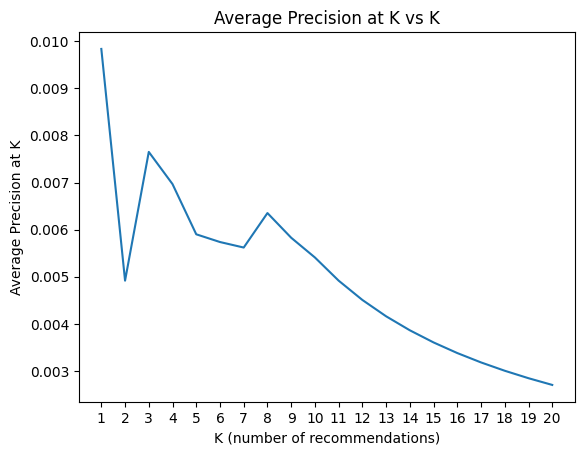

In [21]:
#graph average precision at k with k ranging from 1 to 20

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#using trained moddel generate top k recommendations for each user and then calculate average precision at k
#build a dictionary of k values and their corresponding average precision at k

k_values = {}

#generate top 20 recommendations for each user
recommendations = {}

k = 20

for uid, uvec in user_profiles_norm.items():
    # movies user has already rated (train)
    seen = set(train_ratings[train_ratings['userId'] == uid]['movieId'])
    
    # candidate pool = all movies minus seen
    candidates = genre_matrix.drop(index=seen, errors='ignore')
    
    # compute cosine similarity
    sims = cosine_similarity(uvec.reshape(1, -1), candidates.values)[0]
    
    # grab the Top‑K movieIds
    top_k_ids = candidates.index[np.argsort(sims)[-K:][::-1]]
    recommendations[uid] = list(top_k_ids)

#calculate the average precision at k ranging from 1 to 20 and use to fill k_values dictionary
k = 1
for k in range(1, 21):

    precision_at_k = {}
    for uid, recs in recommendations.items():
        a = 0
        for movie in recs[:k]:
            if movie in good_test_ratings['movieId'][good_test_ratings['userId'] == uid].values:
                a += 1
        precision_at_k[uid] = a / k

        #find average precision at k for all users
    sum_precision = 0
    for uid, recs in precision_at_k.items():
        sum_precision += recs

    average_precision = sum_precision / len(recommendations)
    k_values[k] = average_precision


#plot k_values
plt.plot(list(k_values.keys()), list(k_values.values()))
plt.xlabel('K (number of recommendations)')
plt.ylabel('Average Precision at K')
plt.title('Average Precision at K vs K')
plt.xticks(list(k_values.keys()))
plt.show()

## Confusion Matrix

In [14]:
import matplotlib.pyplot as plt

In [15]:
# Calculate hits and misses (much simpler approach)
hits = 0
misses = 0

In [16]:
# Get movie IDs that each user liked in the test set
for uid in recommendations:
    liked_test_movies = set(good_test_ratings[good_test_ratings['userId'] == uid]['movieId'])
    
    # Count hits and misses among recommendations
    for movie_id in recommendations[uid][:k]:
        if movie_id in liked_test_movies:
            hits += 1
        else:
            misses += 1

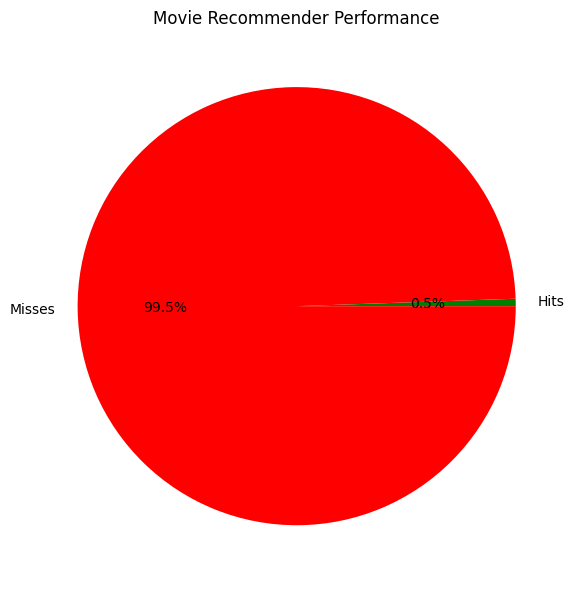

In [17]:
# Simple pie chart
plt.figure(figsize=(6, 6))
plt.pie([hits, misses], 
        labels=['Hits', 'Misses'],
        colors=['green', 'red'],
        autopct='%1.1f%%')
plt.title('Movie Recommender Performance')
plt.tight_layout()
plt.show()

In [18]:
#Simple stats
total = hits + misses
print(f"Total recommendations evaluated: {total}")
print(f"Hits: {hits} ({hits/total:.2%})")
print(f"Misses: {misses} ({misses/total:.2%})")

Total recommendations evaluated: 6100
Hits: 33 (0.54%)
Misses: 6067 (99.46%)


## Storytelling and Conclusion

## Impact Section

## References